## Imports and Setup
Loading all the libraries we need for this project. We're using pandas for data manipulation, matplotlib and seaborn for visualizations, sklearn for machine learning models, and SHAP/LIME for model explainability.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# Load the datasets
hotels = pd.read_csv("/kaggle/input/international-hotel-booking-analytics/hotels.csv" )
reviews = pd.read_csv("/kaggle/input/international-hotel-booking-analytics/reviews.csv")
users = pd.read_csv("/kaggle/input/international-hotel-booking-analytics/users.csv")

# Quick look at the data
print("Hotels shape:", hotels.shape)
print("Reviews shape:", reviews.shape)
print("Users shape:", users.shape)
print("\nFirst few rows of each dataset:")
print(hotels.head())
print(reviews.head())
print(users.head())

Hotels shape: (25, 13)
Reviews shape: (50000, 12)
Users shape: (2000, 6)

First few rows of each dataset:
   hotel_id         hotel_name      city               country  star_rating  \
0         1    The Azure Tower  New York         United States            5   
1         2  The Royal Compass    London        United Kingdom            5   
2         3    L'Étoile Palace     Paris                France            5   
3         4       Kyo-to Grand     Tokyo                 Japan            5   
4         5   The Golden Oasis     Dubai  United Arab Emirates            5   

       lat       lon  cleanliness_base  comfort_base  facilities_base  \
0  40.7580  -73.9855               9.1           8.8              8.9   
1  51.5072   -0.1276               9.0           9.2              8.8   
2  48.8566    2.3522               8.8           9.4              8.7   
3  35.6895  139.6917               9.6           9.0              9.3   
4  25.2769   55.2962               9.3           9.5  

## Loading and Merging Data

Combining the three datasets (reviews, users, hotels) into one big dataframe. We're doing left joins to keep all reviews even if some info is missing.

In [2]:
# merge datasets
data = reviews.merge(users, on='user_id', how='left').merge(hotels, on='hotel_id', how='left')
data.head()

review_id  user_id  hotel_id review_date  score_overall  score_cleanliness  \
0          1     1600         1  2022-10-07            8.7                8.6   
1          2      432         4  2020-03-24            9.1               10.0   
2          3      186        18  2023-12-18            8.8                9.7   
3          4     1403        19  2022-06-22            8.9                9.0   
4          5     1723        17  2022-07-02            9.1                8.9   

   score_comfort  score_facilities  score_location  score_staff  ...  \
0            8.7               8.5             9.0          8.8  ...   
1            9.1               9.0             8.6          9.4  ...   
2            8.8               8.3             8.7          8.1  ...   
3            8.8               8.5             9.6          9.1  ...   
4            9.5               9.3             8.3          9.4  ...   

       country_y star_rating      lat       lon cleanliness_base comfort_base  \
0  United States           5  40.7580  -73.9855              9.1          8.8   
1          Japan           5  35.6895  139.6917              9.6          9.0   
2          Egypt           5  30.0444   31.2357              8.8          8.7   
3          Spain           5  41.3851    2.1734              9.2          9.1   
4         Russia           5  55.7558   37.6173              9.1          9.3   

  facilities_base location_base staff_base value_for_money_base  
0             8.9           9.5        8.6                  8.0  
1             9.3           8.5        9.5                  8.2  
2             8.6           9.1        8.7                  8.4  
3             8.9           9.7        9.0                  8.8  
4             9.0           9.0        9.1                  8.6  

[5 rows x 29 columns]

### Quick Look at the Data

Let's see what we're working with - checking the shape, column names, and first few rows to understand the structure.

In [3]:
# Display basic information about the merged dataset
print("Dataset Shape:", data.shape)
print("\nColumn Names:")
print(data.columns.tolist())
print("\nFirst few rows:")
data.head()

Dataset Shape: (50000, 29)

Column Names:
['review_id', 'user_id', 'hotel_id', 'review_date', 'score_overall', 'score_cleanliness', 'score_comfort', 'score_facilities', 'score_location', 'score_staff', 'score_value_for_money', 'review_text', 'user_gender', 'country_x', 'age_group', 'traveller_type', 'join_date', 'hotel_name', 'city', 'country_y', 'star_rating', 'lat', 'lon', 'cleanliness_base', 'comfort_base', 'facilities_base', 'location_base', 'staff_base', 'value_for_money_base']

First few rows:


review_id  user_id  hotel_id review_date  score_overall  score_cleanliness  \
0          1     1600         1  2022-10-07            8.7                8.6   
1          2      432         4  2020-03-24            9.1               10.0   
2          3      186        18  2023-12-18            8.8                9.7   
3          4     1403        19  2022-06-22            8.9                9.0   
4          5     1723        17  2022-07-02            9.1                8.9   

   score_comfort  score_facilities  score_location  score_staff  ...  \
0            8.7               8.5             9.0          8.8  ...   
1            9.1               9.0             8.6          9.4  ...   
2            8.8               8.3             8.7          8.1  ...   
3            8.8               8.5             9.6          9.1  ...   
4            9.5               9.3             8.3          9.4  ...   

       country_y star_rating      lat       lon cleanliness_base comfort_base  \
0  United States           5  40.7580  -73.9855              9.1          8.8   
1          Japan           5  35.6895  139.6917              9.6          9.0   
2          Egypt           5  30.0444   31.2357              8.8          8.7   
3          Spain           5  41.3851    2.1734              9.2          9.1   
4         Russia           5  55.7558   37.6173              9.1          9.3   

  facilities_base location_base staff_base value_for_money_base  
0             8.9           9.5        8.6                  8.0  
1             9.3           8.5        9.5                  8.2  
2             8.6           9.1        8.7                  8.4  
3             8.9           9.7        9.0                  8.8  
4             9.0           9.0        9.1                  8.6  

[5 rows x 29 columns]

### Data Quality Check

Before we do anything else, we need to check for missing values and duplicates. This helps us know if we need to clean anything up.

In [4]:
# Check for missing values
print("Missing Values:")
print(data.isnull().sum())
print("\nDuplicate Rows:", data.duplicated().sum())

Missing Values:
review_id                0
user_id                  0
hotel_id                 0
review_date              0
score_overall            0
score_cleanliness        0
score_comfort            0
score_facilities         0
score_location           0
score_staff              0
score_value_for_money    0
review_text              0
user_gender              0
country_x                0
age_group                0
traveller_type           0
join_date                0
hotel_name               0
city                     0
country_y                0
star_rating              0
lat                      0
lon                      0
cleanliness_base         0
comfort_base             0
facilities_base          0
location_base            0
staff_base               0
value_for_money_base     0
dtype: int64

Duplicate Rows: 0


## Exploratory Data Analysis (EDA)

### Distribution of Hotels by Country

Visualizing where all the hotels in our dataset are located. This gives us an idea of which countries are most represented.

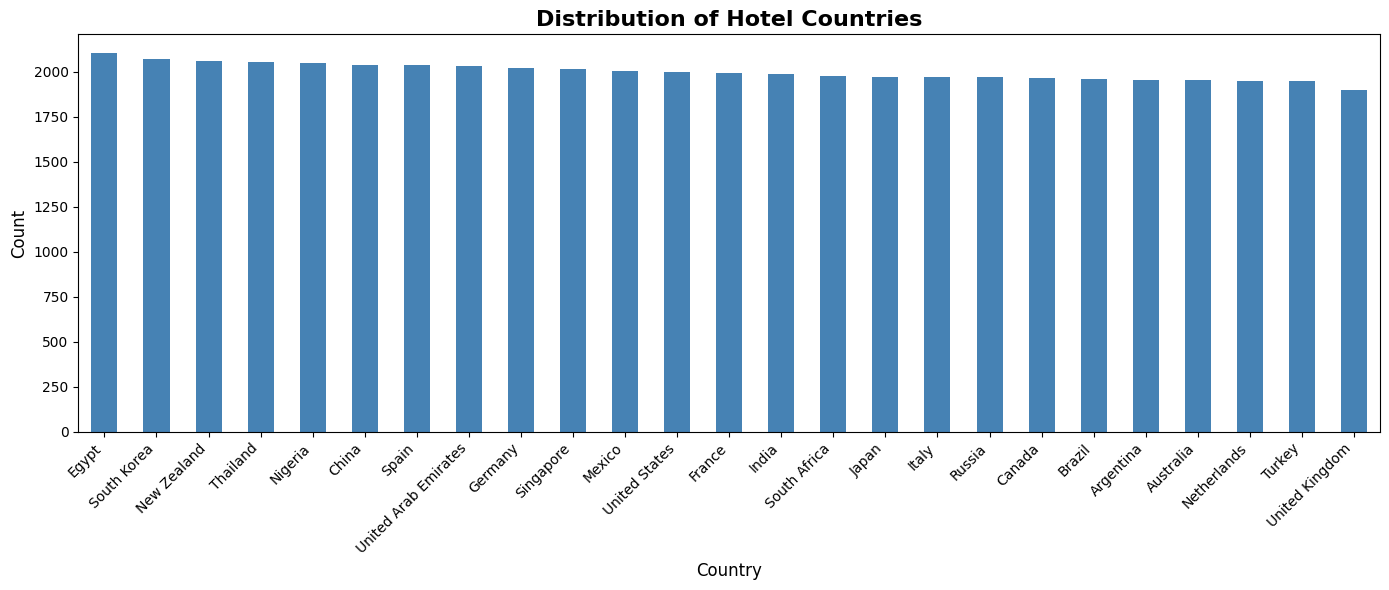

In [5]:
# Visualize distribution of hotel countries (before grouping)
plt.figure(figsize=(14, 6))
data['country_y'].value_counts().plot(kind='bar', color='steelblue')
plt.title('Distribution of Hotel Countries', fontsize=16, fontweight='bold')
plt.xlabel('Country', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### User Demographics Overview
Breaking down who our users are - their age groups, gender distribution, traveler types, and where they're from. This helps us understand our customer base.

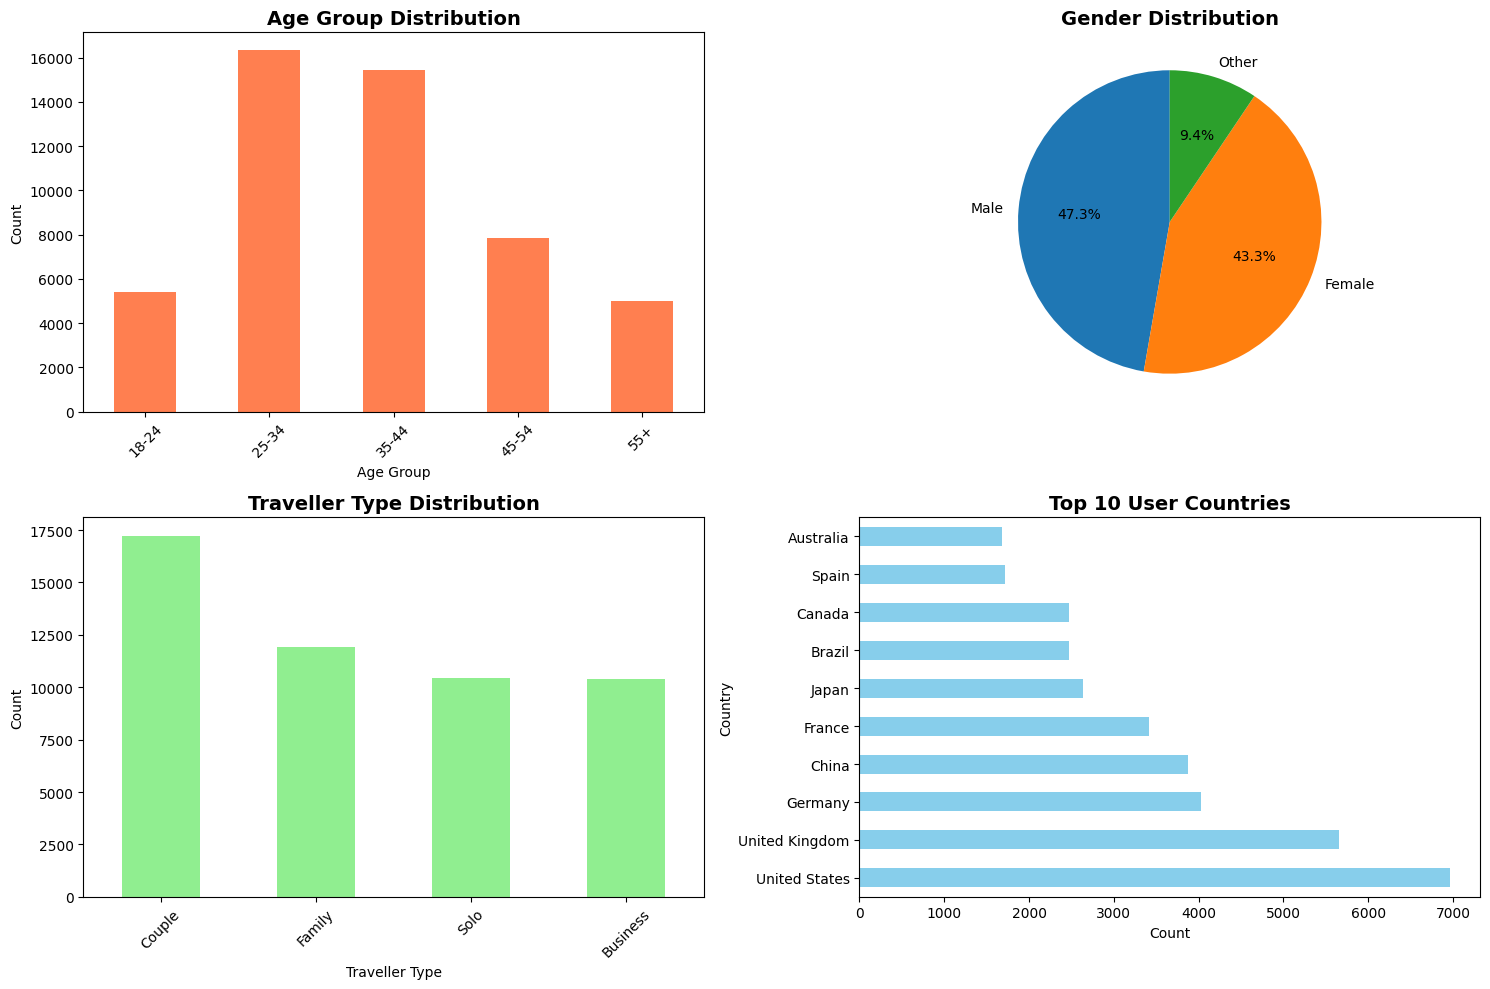

In [6]:
# User Demographics Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Age group distribution
data['age_group'].value_counts().sort_index().plot(kind='bar', ax=axes[0,0], color='coral')
axes[0,0].set_title('Age Group Distribution', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Age Group')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=45)

# Gender distribution
data['user_gender'].value_counts().plot(kind='pie', ax=axes[0,1], autopct='%1.1f%%', startangle=90)
axes[0,1].set_title('Gender Distribution', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('')

# Traveller type distribution
data['traveller_type'].value_counts().plot(kind='bar', ax=axes[1,0], color='lightgreen')
axes[1,0].set_title('Traveller Type Distribution', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Traveller Type')
axes[1,0].set_ylabel('Count')
axes[1,0].tick_params(axis='x', rotation=45)

# Top user countries
data['country_x'].value_counts().head(10).plot(kind='barh', ax=axes[1,1], color='skyblue')
axes[1,1].set_title('Top 10 User Countries', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Count')
axes[1,1].set_ylabel('Country')

plt.tight_layout()
plt.show()

### Review Scores Distribution

Looking at how users rate different aspects of hotels (cleanliness, comfort, location, etc.). The histograms show us if people generally rate things high or low, and the red line shows the average for each category.

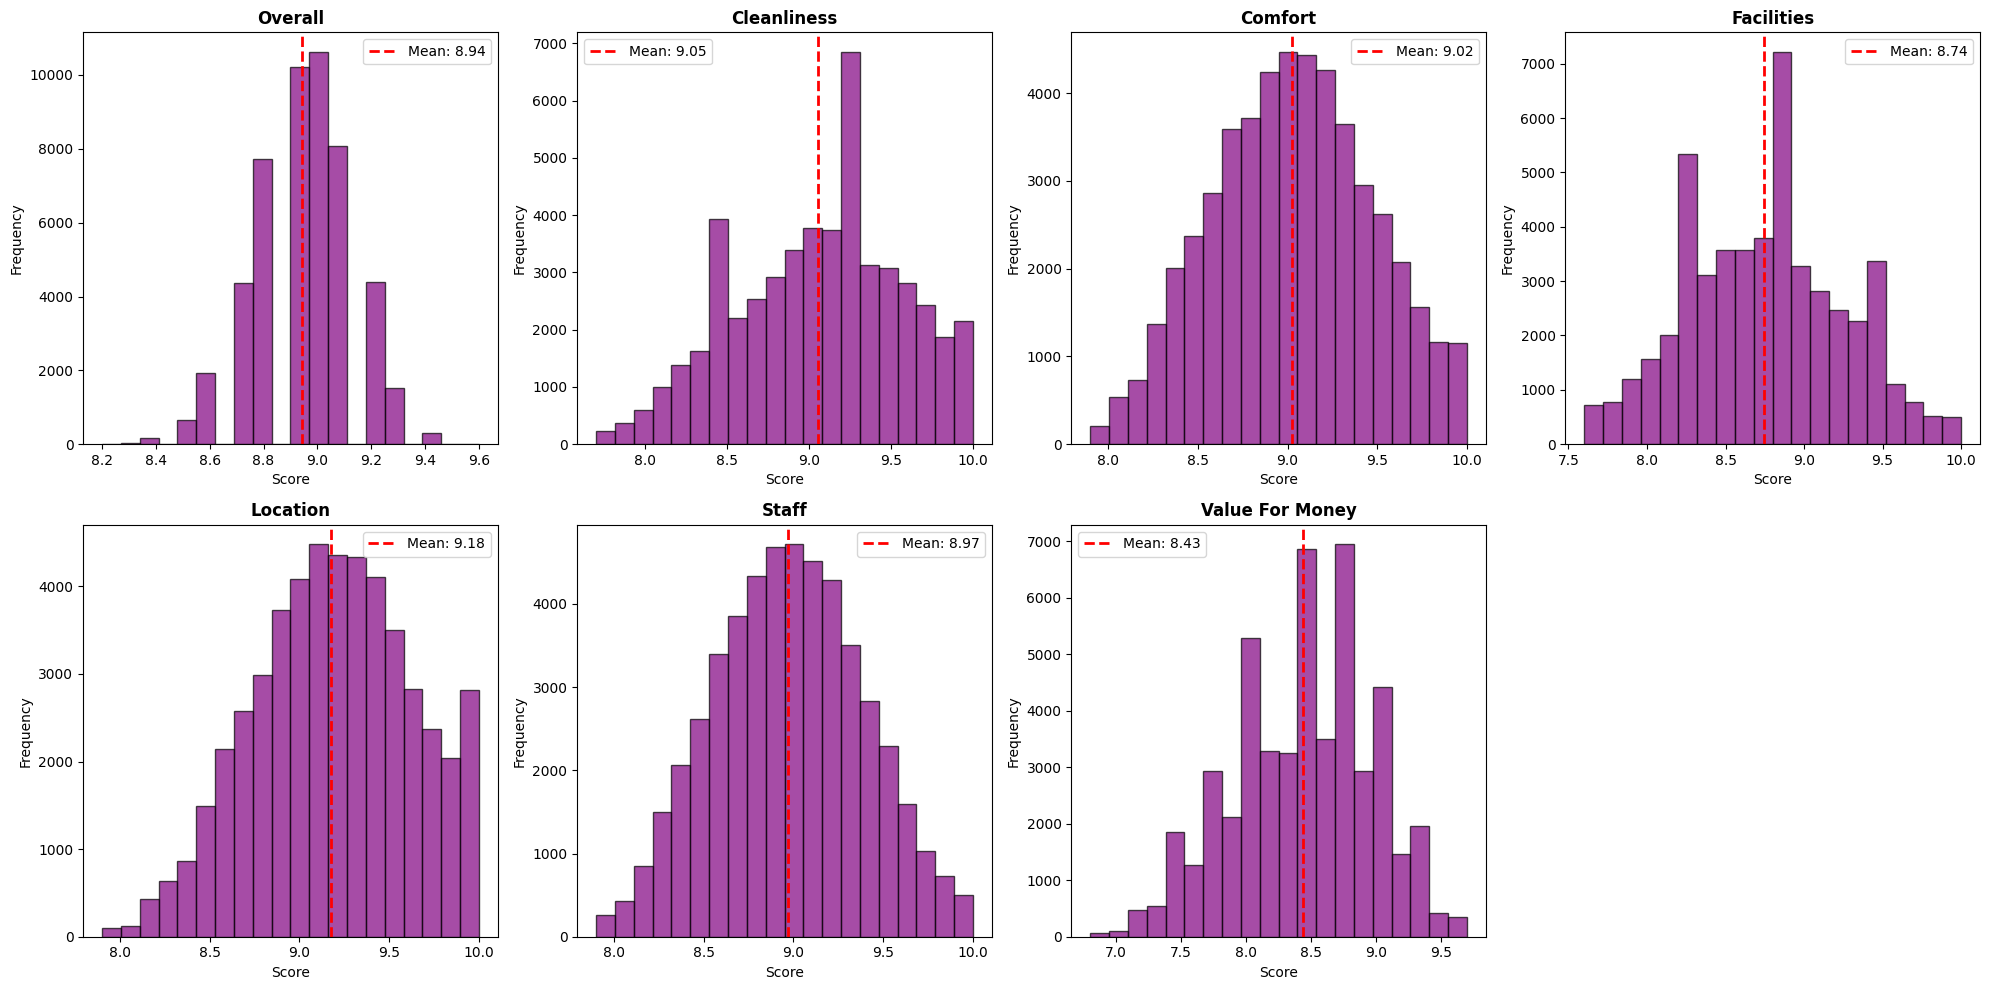


Score Summary Statistics:
       score_overall  score_cleanliness  score_comfort  score_facilities  \
count   50000.000000       50000.000000   50000.000000      50000.000000   
mean        8.943460           9.052558       9.024404          8.743062   
std         0.180878           0.504296       0.423927          0.498320   
min         8.200000           7.700000       7.900000          7.600000   
25%         8.800000           8.700000       8.700000          8.400000   
50%         8.900000           9.100000       9.000000          8.700000   
75%         9.100000           9.400000       9.300000          9.100000   
max         9.600000          10.000000      10.000000         10.000000   

       score_location   score_staff  score_value_for_money  
count    50000.000000  50000.000000           50000.000000  
mean         9.176410      8.972076               8.434540  
std          0.421086      0.397775               0.529321  
min          7.900000      7.900000         

In [7]:
# Review Scores Distribution
score_columns = ['score_overall', 'score_cleanliness', 'score_comfort', 
                 'score_facilities', 'score_location', 'score_staff', 'score_value_for_money']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, col in enumerate(score_columns):
    axes[idx].hist(data[col], bins=20, color='purple', alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'{col.replace("score_", "").replace("_", " ").title()}', 
                        fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Score')
    axes[idx].set_ylabel('Frequency')
    axes[idx].axvline(data[col].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data[col].mean():.2f}')
    axes[idx].legend()

# Remove the last empty subplot
fig.delaxes(axes[7])

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nScore Summary Statistics:")
print(data[score_columns].describe())

### How Different Scores Relate to Each Other

This heatmap shows which rating categories tend to move together. For example, if cleanliness is high, is comfort usually high too? Understanding these relationships helps us see patterns in user ratings.

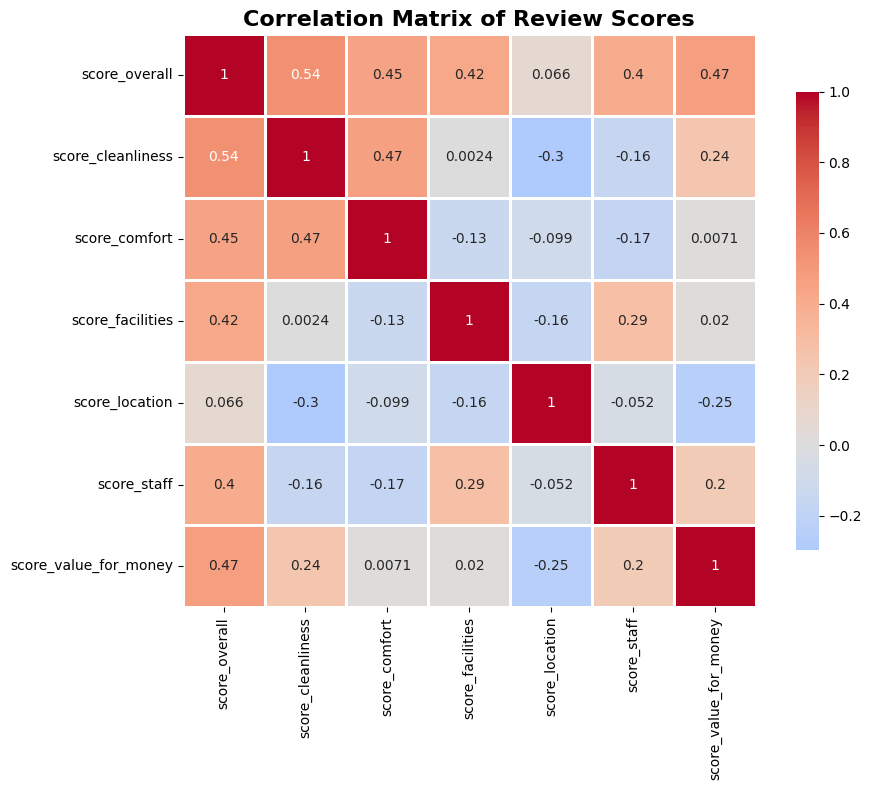

In [8]:
# Correlation matrix for score columns
plt.figure(figsize=(10, 8))
correlation_matrix = data[score_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Review Scores', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Data Preprocessing

### Checking Available Columns

Taking a look at all the columns we have before we start cleaning and transforming the data.

In [9]:
# see the merged columns
data.columns.tolist()

['review_id',
 'user_id',
 'hotel_id',
 'review_date',
 'score_overall',
 'score_cleanliness',
 'score_comfort',
 'score_facilities',
 'score_location',
 'score_staff',
 'score_value_for_money',
 'review_text',
 'user_gender',
 'country_x',
 'age_group',
 'traveller_type',
 'join_date',
 'hotel_name',
 'city',
 'country_y',
 'star_rating',
 'lat',
 'lon',
 'cleanliness_base',
 'comfort_base',
 'facilities_base',
 'location_base',
 'staff_base',
 'value_for_money_base']

### Creating Country Groups

Instead of having 50+ individual countries, we're grouping them into regions (like North America, Western Europe, etc.). This makes the classification problem more manageable and gives us more data per category.

In [10]:
country_group_map = {
            # North America
            'United States': 'North_America',
            'Canada': 'North_America',
            
            # Western Europe
            'Germany': 'Western_Europe',
            'France': 'Western_Europe',
            'United Kingdom': 'Western_Europe',
            'Netherlands': 'Western_Europe',
            'Spain': 'Western_Europe',
            'Italy': 'Western_Europe',
            
            # Eastern Europe
            'Russia': 'Eastern_Europe',
            
            # East Asia
            'China': 'East_Asia',
            'Japan': 'East_Asia',
            'South Korea': 'East_Asia',
            
            # Southeast Asia
            'Thailand': 'Southeast_Asia',
            'Singapore': 'Southeast_Asia',
            
            # Middle East
            'United Arab Emirates': 'Middle_East',
            'Turkey': 'Middle_East',
            
            # Africa
            'Egypt': 'Africa',
            'Nigeria': 'Africa',
            'South Africa': 'Africa',
            
            # Oceania
            'Australia': 'Oceania',
            'New Zealand': 'Oceania',
            
            # South America
            'Brazil': 'South_America',
            'Argentina': 'South_America',
            
            # South Asia
            'India': 'South_Asia',
            
            # Mexico
            'Mexico': 'North_America_Mexico'
        }

### Preprocessing Function

This function handles all the data cleaning and transformation:
- Renames columns to avoid confusion
- Drops unnecessary columns (like IDs, dates, text reviews)
- Encodes categorical variables (gender, age group)
- Creates one-hot encoding for traveler type and user country
- Maps hotel countries to their regional groups

The MODE parameter lets us use the same function for training and testing data.

In [11]:

def preprocessing(data, MODE="TRAIN"):
    data = data.copy()
    
    if(MODE =="TRAIN"):
        data = data.rename(columns={
            'country_y': 'hotel_country',
            'country_x': 'user_country'
        })
    
    else:
        data = data.rename(columns={
            'country_x': 'user_country'
        })
        
    

    columns_to_drop = [
        'review_id', 'user_id', 'hotel_id', 'join_date', 'hotel_name',
        'review_date', 'lat', 'lon', 'star_rating', 'review_text', 'city'
    ]
    existing_cols_to_drop = [col for col in columns_to_drop if col in data.columns]
    if existing_cols_to_drop:
        data = data.drop(columns=existing_cols_to_drop)
        print(f"Dropped columns: {existing_cols_to_drop}")
    else:
        print("No unnecessary columns to drop.")

    # Encode user_gender
    if 'user_gender' in data.columns:
        data['user_gender'] = data['user_gender'].replace({
            'Male': 0, 'Female': 1, 'Other': 2
        })
        print("Encoded user_gender.")
    else:
        print("user_gender not found, skipping encoding.")

    # Encode age_group

    if 'age_group' in data.columns:
        age_order = {'18-24': 0, '25-34': 1, '35-44': 2, '45-54': 3, '55+': 4}
        data['age_encoded'] = data['age_group'].map(age_order)
        data.drop(columns=['age_group'], inplace=True)
        print("Encoded age_group → age_encoded.")
    else:
        print("age_group not found, skipping encoding.")

    # One-hot encode traveller_type

    if 'traveller_type' in data.columns:
        data = pd.get_dummies(data, columns=['traveller_type'], prefix='traveller')
        print("One-hot encoded traveller_type.")
    else:
        print("traveller_type not found, skipping one-hot encoding.")

    # One-hot encode user_country
    if 'user_country' in data.columns:
        data = pd.get_dummies(data, columns=['user_country'], prefix='user_country')
        print("One-hot encoded user_country.")
    else:
        print("user_country not found, skipping one-hot encoding.")

    if(MODE == "TRAIN"):

        # Create the country_group column from HOTEL's country (this is our target variable)
        data['country_group'] = data['hotel_country'].map(country_group_map)
        data.drop(columns=['hotel_country'], inplace=True)


        # =============================
    # ✅ Ensure all required model columns exist
    # =============================
    required_columns = [
        'score_overall', 'score_cleanliness', 'score_comfort', 'score_facilities',
        'score_location', 'score_staff', 'score_value_for_money', 'user_gender',
        'age_encoded', 'traveller_Business', 'traveller_Couple', 'traveller_Family',
        'traveller_Friends', 'traveller_Solo', 'user_country_Australia',
        'user_country_Austria', 'user_country_Belgium', 'user_country_Brazil',
        'user_country_Canada', 'user_country_China', 'user_country_Czech Republic',
        'user_country_Denmark', 'user_country_Egypt', 'user_country_Finland',
        'user_country_France', 'user_country_Germany', 'user_country_Greece',
        'user_country_Hong Kong', 'user_country_Hungary', 'user_country_India',
        'user_country_Indonesia', 'user_country_Ireland', 'user_country_Italy',
        'user_country_Japan', 'user_country_Malaysia', 'user_country_Mexico',
        'user_country_Netherlands', 'user_country_New Zealand', 'user_country_Norway',
        'user_country_Poland', 'user_country_Portugal', 'user_country_Qatar',
        'user_country_Russia', 'user_country_Singapore', 'user_country_South Africa',
        'user_country_South Korea', 'user_country_Spain', 'user_country_Thailand',
        'user_country_Turkey', 'user_country_United Arab Emirates',
        'user_country_United Kingdom', 'user_country_United States',
        'user_country_Argentina', 'user_country_Nigeria'
    ]
    for col in required_columns:
        if col not in data.columns:
            # If it’s a boolean column, fill with False; else numeric columns get 0
            if col.startswith("traveller_") or col.startswith("user_country_"):
                data[col] = False
            else:
                data[col] = 0

    # Ensure column order matches the model input
    data = data[[col for col in required_columns if col in data.columns] + 
                [col for col in data.columns if col not in required_columns]]


    
    print("Preprocessed Data")
    print(data.head())

    return data


### Applying Preprocessing

Running the preprocessing function on our data in TRAIN mode to get it ready for modeling.

In [12]:
data = preprocessing(data, "TRAIN")
data.head()

Dropped columns: ['review_id', 'user_id', 'hotel_id', 'join_date', 'hotel_name', 'review_date', 'lat', 'lon', 'star_rating', 'review_text', 'city']
Encoded user_gender.
Encoded age_group → age_encoded.
One-hot encoded traveller_type.
One-hot encoded user_country.
Preprocessed Data
   score_overall  score_cleanliness  score_comfort  score_facilities  \
0            8.7                8.6            8.7               8.5   
1            9.1               10.0            9.1               9.0   
2            8.8                9.7            8.8               8.3   
3            8.9                9.0            8.8               8.5   
4            9.1                8.9            9.5               9.3   

   score_location  score_staff  score_value_for_money  user_gender  \
0             9.0          8.8                    8.7            1   
1             8.6          9.4                    8.6            1   
2             8.7          8.1                    8.6            1   
3    

score_overall  score_cleanliness  score_comfort  score_facilities  \
0            8.7                8.6            8.7               8.5   
1            9.1               10.0            9.1               9.0   
2            8.8                9.7            8.8               8.3   
3            8.9                9.0            8.8               8.5   
4            9.1                8.9            9.5               9.3   

   score_location  score_staff  score_value_for_money  user_gender  \
0             9.0          8.8                    8.7            1   
1             8.6          9.4                    8.6            1   
2             8.7          8.1                    8.6            1   
3             9.6          9.1                    8.3            1   
4             8.3          9.4                    8.9            0   

   age_encoded  traveller_Business  ...  user_country_United States  \
0            1               False  ...                       False   
1            2               False  ...                       False   
2            4               False  ...                       False   
3            2                True  ...                       False   
4            3               False  ...                       False   

   user_country_Argentina  user_country_Nigeria  cleanliness_base  \
0                   False                 False               9.1   
1                   False                 False               9.6   
2                   False                 False               8.8   
3                   False                 False               9.2   
4                   False                 False               9.1   

   comfort_base  facilities_base  location_base  staff_base  \
0           8.8              8.9            9.5         8.6   
1           9.0              9.3            8.5         9.5   
2           8.7              8.6            9.1         8.7   
3           9.1              8.9            9.7         9.0   
4           9.3              9.0            9.0         9.1   

   value_for_money_base   country_group  
0                   8.0   North_America  
1                   8.2       East_Asia  
2                   8.4          Africa  
3                   8.8  Western_Europe  
4                   8.6  Eastern_Europe  

[5 rows x 61 columns]

### Target Variable Distribution

Now that we've created country groups, let's visualize how balanced they are. The bar chart and pie chart show us if some groups are overrepresented (which could affect model performance).

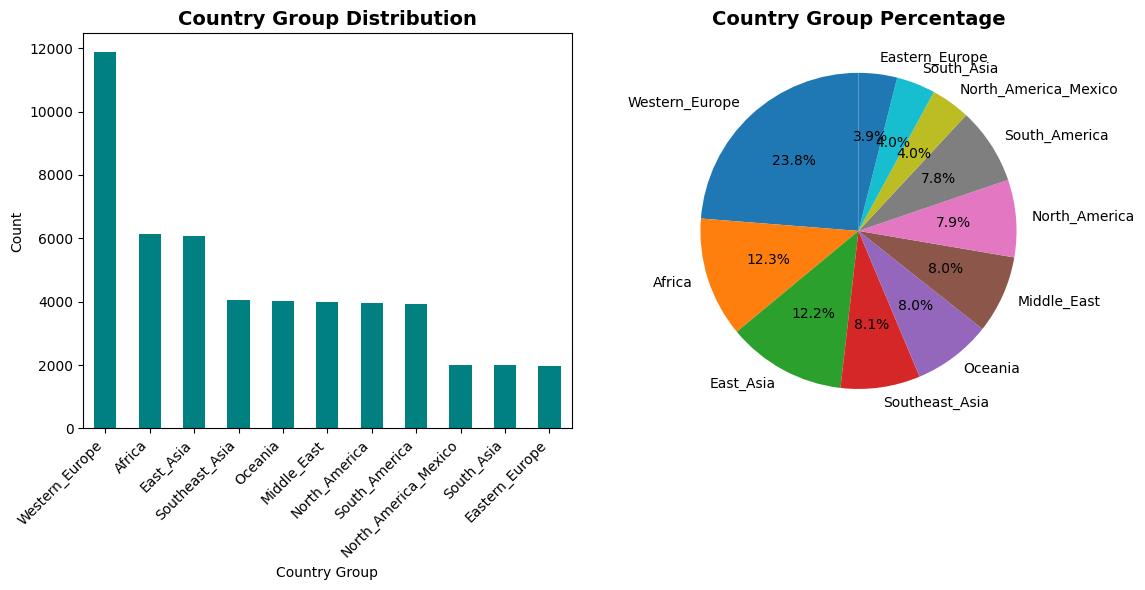


Country Group Counts:
country_group
Western_Europe          11876
Africa                   6132
East_Asia                6082
Southeast_Asia           4070
Oceania                  4014
Middle_East              3983
North_America            3962
South_America            3918
North_America_Mexico     2004
South_Asia               1989
Eastern_Europe           1970
Name: count, dtype: int64


In [13]:
# Visualize the target variable (country_group) distribution
plt.figure(figsize=(12, 6))
country_counts = data['country_group'].value_counts()
plt.subplot(1, 2, 1)
country_counts.plot(kind='bar', color='teal')
plt.title('Country Group Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Country Group')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
country_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Country Group Percentage', fontsize=14, fontweight='bold')
plt.ylabel('')

plt.tight_layout()
plt.show()

print("\nCountry Group Counts:")
print(country_counts)

Quick numerical summary of how many samples we have per country group.

In [14]:
data.country_group.value_counts()

country_group
Western_Europe          11876
Africa                   6132
East_Asia                6082
Southeast_Asia           4070
Oceania                  4014
Middle_East              3983
North_America            3962
South_America            3918
North_America_Mexico     2004
South_Asia               1989
Eastern_Europe           1970
Name: count, dtype: int64

## Model Training

### Model 1: Baseline without Base Features

Training our first model. We're removing the base rating columns (cleanliness_base, comfort_base, etc.) to avoid data leakage - these are hotel characteristics that might unfairly help the model predict.

Using Random Forest with 500 trees as our classifier. We'll see how well it performs with just user demographics and review scores.

In [15]:
# Model 1 
# create a model that trains on the data to predict the country_group based on the current remaining features
# for the first model we'll remove the base rating columns to avoid data leakage
X = data.drop(columns=['country_group', 'comfort_base', 'facilities_base', 'location_base', 'staff_base', 'value_for_money_base', 'cleanliness_base'
])
y = data['country_group']
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state=42)
rf_1 = RandomForestClassifier(n_estimators=500, random_state=42)
rf_1.fit(X_train_1, y_train_1)
y_tr = rf_1.predict(X_train_1)
y_pred_1 = rf_1.predict(X_test_1)
train_accuracy = accuracy_score(y_train_1, y_tr)
test_accuracy = accuracy_score(y_test_1, y_pred_1)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print(classification_report(y_test_1, y_pred_1))

Train Accuracy: 1.0
Test Accuracy: 0.3893
                      precision    recall  f1-score   support

              Africa       0.38      0.46      0.41      1247
           East_Asia       0.43      0.46      0.44      1195
      Eastern_Europe       0.22      0.06      0.09       358
         Middle_East       0.44      0.23      0.30       816
       North_America       0.42      0.23      0.30       776
North_America_Mexico       0.28      0.09      0.14       400
             Oceania       0.33      0.10      0.16       805
       South_America       0.31      0.22      0.26       813
          South_Asia       0.14      0.03      0.05       389
      Southeast_Asia       0.40      0.19      0.26       818
      Western_Europe       0.40      0.80      0.53      2383

            accuracy                           0.39     10000
           macro avg       0.34      0.26      0.27     10000
        weighted avg       0.37      0.39      0.35     10000



### Model 1 Results: Confusion Matrix

The confusion matrix shows us where the model gets things right and where it gets confused. Each cell shows how many predictions fell into each category.

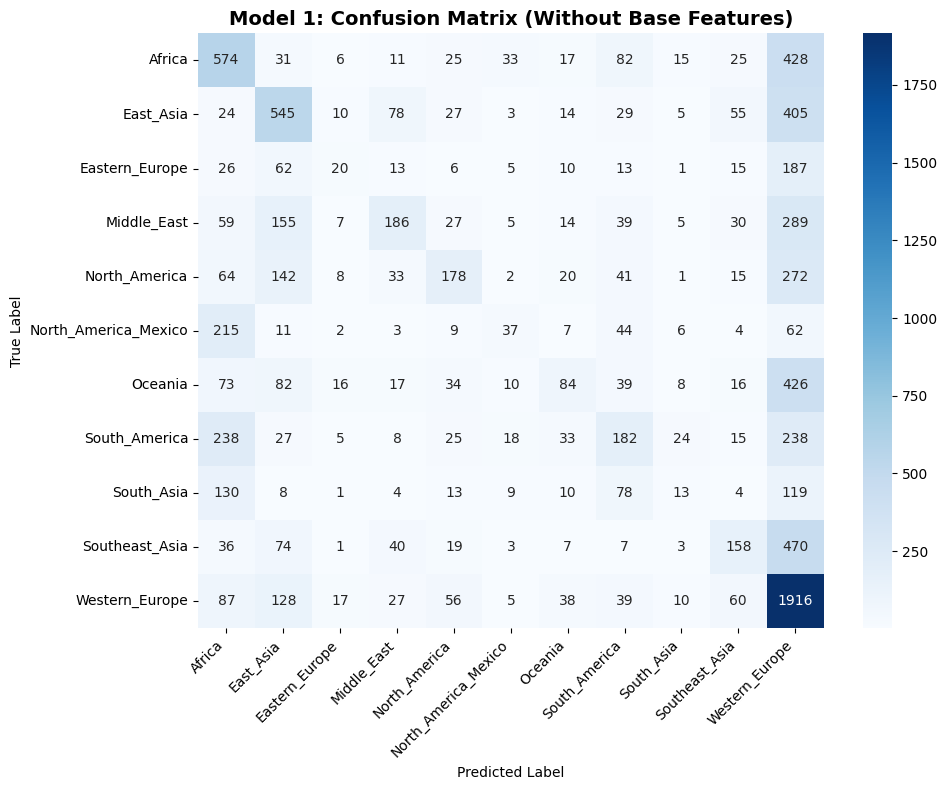

In [16]:
# Model 1: Confusion Matrix
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1, y_pred_1)
plt.figure(figsize=(10, 8))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', 
            xticklabels=rf_1.classes_, yticklabels=rf_1.classes_)
plt.title('Model 1: Confusion Matrix (Without Base Features)', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Model 1: Which Features Matter Most?

Feature importance tells us which variables the model relies on most for predictions. This helps us understand what drives the country group classification.

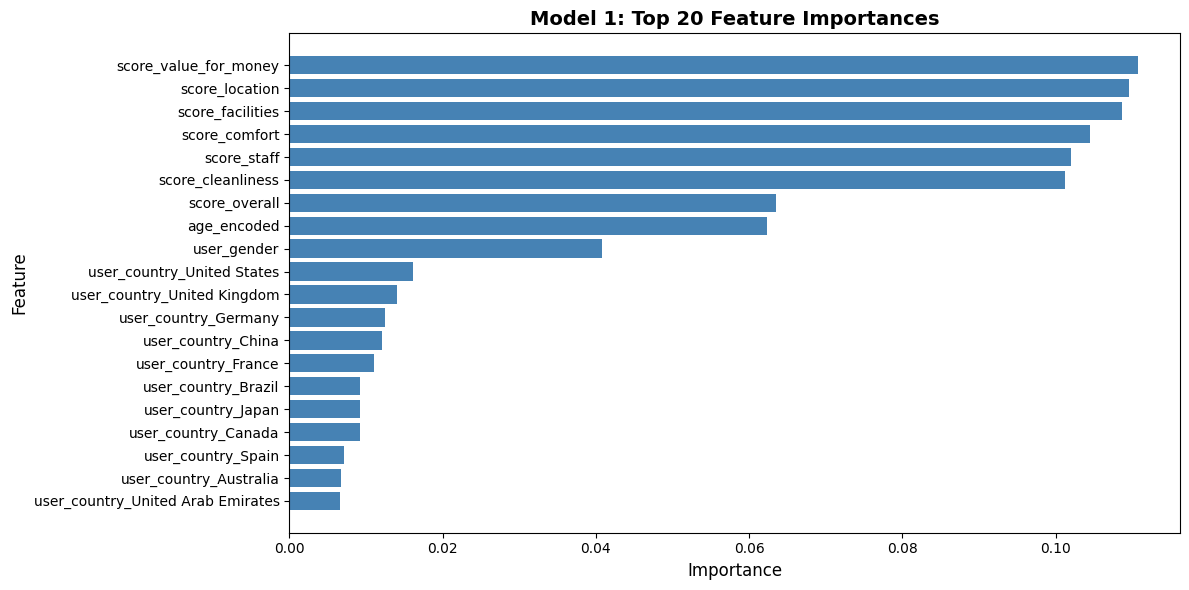

Top 10 Most Important Features for Model 1:
                       feature  importance
6        score_value_for_money    0.110696
4               score_location    0.109581
3             score_facilities    0.108681
2                score_comfort    0.104514
5                  score_staff    0.101982
1            score_cleanliness    0.101273
0                score_overall    0.063480
8                  age_encoded    0.062308
7                  user_gender    0.040831
51  user_country_United States    0.016186


In [17]:
# Model 1: Feature Importance
feature_importance_1 = pd.DataFrame({
    'feature': X_train_1.columns,
    'importance': rf_1.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(feature_importance_1.head(20)['feature'], 
         feature_importance_1.head(20)['importance'], 
         color='steelblue')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Model 1: Top 20 Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features for Model 1:")
print(feature_importance_1.head(10))

### Model 2: Adding Averaged Base Features

For this model, we're creating a new feature - the average of all base ratings. This single number represents the hotel's overall baseline quality without giving away too much info about specific aspects.

Let's see if this helps the model perform better.

In [18]:
# Model 2
# create a model that trains on the data to predict the country_group based on features including an engineered average for base ratings
# the average will be rounded to 1 decimal place which might help reduce noise and cluster the data better but could also cause partial leakage
model2_data = data.copy()
model2_data['hotel_avg_base'] = model2_data[['cleanliness_base', 'comfort_base', 'facilities_base', 
                                'location_base', 'staff_base', 'value_for_money_base']].mean(axis=1).round(1)
X = model2_data.drop(columns=['country_group', 'comfort_base', 'facilities_base', 'location_base', 'staff_base', 'value_for_money_base', 'cleanliness_base'
])
y = model2_data['country_group']
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=42)
rf_2 = RandomForestClassifier(n_estimators=500, random_state=42)
rf_2.fit(X_train_2, y_train_2)
y_tr = rf_2.predict(X_train_2)
y_pred_2 = rf_2.predict(X_test_2)
train_accuracy = accuracy_score(y_train_2, y_tr)
test_accuracy = accuracy_score(y_test_2, y_pred_2)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print(classification_report(y_test_2, y_pred_2))

Train Accuracy: 1.0
Test Accuracy: 0.6023
                      precision    recall  f1-score   support

              Africa       0.72      0.71      0.71      1247
           East_Asia       0.57      0.55      0.56      1195
      Eastern_Europe       0.65      0.53      0.58       358
         Middle_East       0.75      0.68      0.71       816
       North_America       0.67      0.55      0.61       776
North_America_Mexico       0.67      0.47      0.55       400
             Oceania       0.50      0.28      0.36       805
       South_America       0.53      0.61      0.57       813
          South_Asia       0.50      0.37      0.43       389
      Southeast_Asia       0.58      0.39      0.46       818
      Western_Europe       0.56      0.82      0.67      2383

            accuracy                           0.60     10000
           macro avg       0.61      0.54      0.56     10000
        weighted avg       0.61      0.60      0.59     10000



### Model 2 Results: Confusion Matrix

Checking if adding that average base feature improved our predictions.

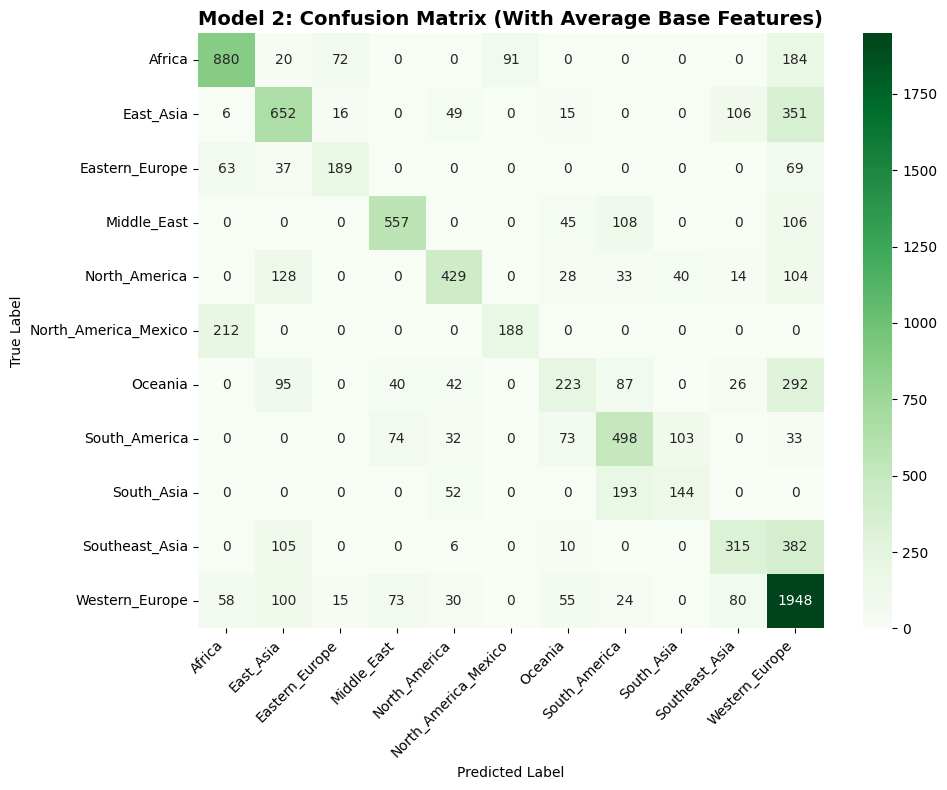

In [19]:
# Model 2: Confusion Matrix
cm2 = confusion_matrix(y_test_2, y_pred_2)
plt.figure(figsize=(10, 8))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', 
            xticklabels=rf_2.classes_, yticklabels=rf_2.classes_)
plt.title('Model 2: Confusion Matrix (With Average Base Features)', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Model 2: Feature Importance Analysis

Is that averaged base rating important? Let's see where it ranks among all features.

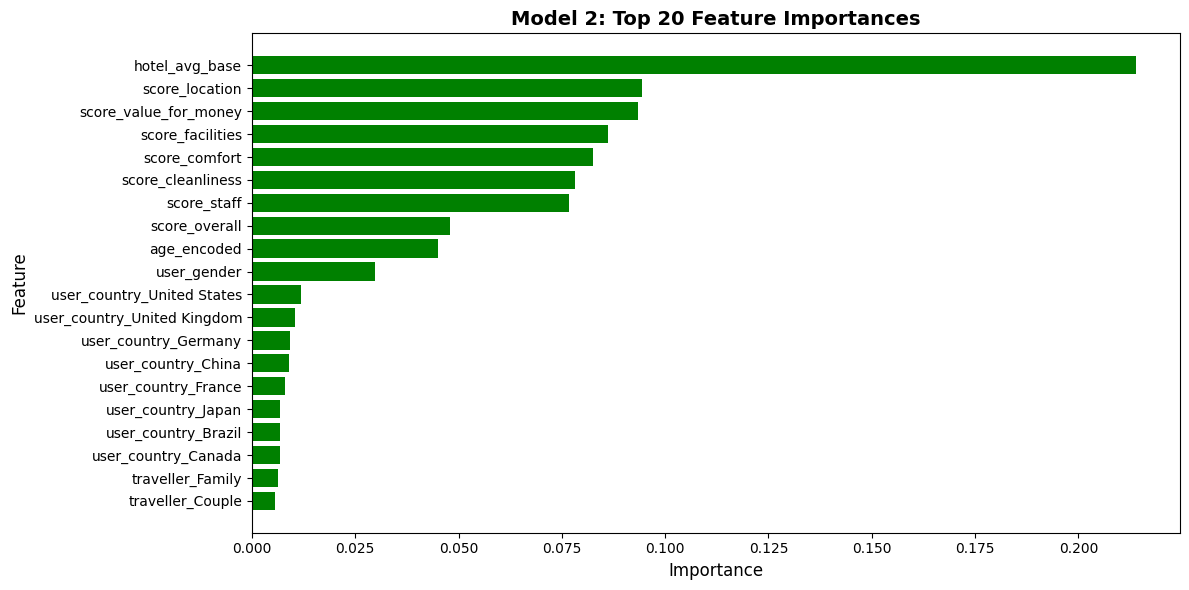

Top 10 Most Important Features for Model 2:
                  feature  importance
54         hotel_avg_base    0.213887
4          score_location    0.094474
6   score_value_for_money    0.093472
3        score_facilities    0.086193
2           score_comfort    0.082446
1       score_cleanliness    0.078219
5             score_staff    0.076839
0           score_overall    0.047891
8             age_encoded    0.045015
7             user_gender    0.029738


In [20]:
# Model 2: Feature Importance
feature_importance_2 = pd.DataFrame({
    'feature': X_train_2.columns,
    'importance': rf_2.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(feature_importance_2.head(20)['feature'], 
         feature_importance_2.head(20)['importance'], 
         color='green')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Model 2: Top 20 Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features for Model 2:")
print(feature_importance_2.head(10))

### Model 3: Engineering Gap Features

This model gets creative - we're calculating the 'gap' between base ratings and actual review scores. For example, if a hotel has a cleanliness_base of 8.5 but gets review scores of 7.0, there's a negative gap.

These gap features might capture whether hotels are overperforming or underperforming relative to their baseline. Could be powerful but might also introduce some data leakage since it combines both pieces of info.

In [21]:
# Model 3
# create a model that trains on the data to predict the country_group based on features including new features that were engineered
# from the difference between the review scores and base scores which might cause data leakage 
# because of the correlation between the difference and the score
model3_data = data.copy()
model3_data['cleanliness_gap'] = model3_data['cleanliness_base'] - model3_data['score_cleanliness']
model3_data['comfort_gap'] = model3_data['comfort_base'] - model3_data['score_comfort']
model3_data['facilities_gap'] = model3_data['facilities_base'] - model3_data['score_facilities']
model3_data['location_gap'] = model3_data['location_base'] - model3_data['score_location']
model3_data['staff_gap'] = model3_data['staff_base'] - model3_data['score_staff']
model3_data['value_gap'] = model3_data['value_for_money_base'] - model3_data['score_value_for_money']
X = model3_data.drop(columns=['country_group', 'comfort_base', 'facilities_base', 'location_base', 'staff_base', 'value_for_money_base', 'cleanliness_base'
])
y = model3_data['country_group']
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, y, test_size=0.2, random_state=42)
rf_3 = RandomForestClassifier(n_estimators=500, random_state=42)
rf_3.fit(X_train_3, y_train_3)
y_tr = rf_3.predict(X_train_3)
y_pred_3 = rf_3.predict(X_test_3)
train_accuracy = accuracy_score(y_train_3, y_tr)
test_accuracy = accuracy_score(y_test_3, y_pred_3)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print(classification_report(y_test_3, y_pred_3))

Train Accuracy: 1.0
Test Accuracy: 0.8103
                      precision    recall  f1-score   support

              Africa       0.79      0.70      0.74      1247
           East_Asia       0.92      0.82      0.87      1195
      Eastern_Europe       0.90      0.64      0.75       358
         Middle_East       0.99      0.77      0.87       816
       North_America       0.98      0.92      0.95       776
North_America_Mexico       1.00      0.52      0.68       400
             Oceania       0.96      0.73      0.83       805
       South_America       0.73      0.95      0.83       813
          South_Asia       0.80      0.30      0.44       389
      Southeast_Asia       0.98      0.78      0.87       818
      Western_Europe       0.66      0.99      0.80      2383

            accuracy                           0.81     10000
           macro avg       0.88      0.74      0.78     10000
        weighted avg       0.85      0.81      0.81     10000



### Model 3 Results: Confusion Matrix

Did those gap features help? Let's check the confusion matrix.

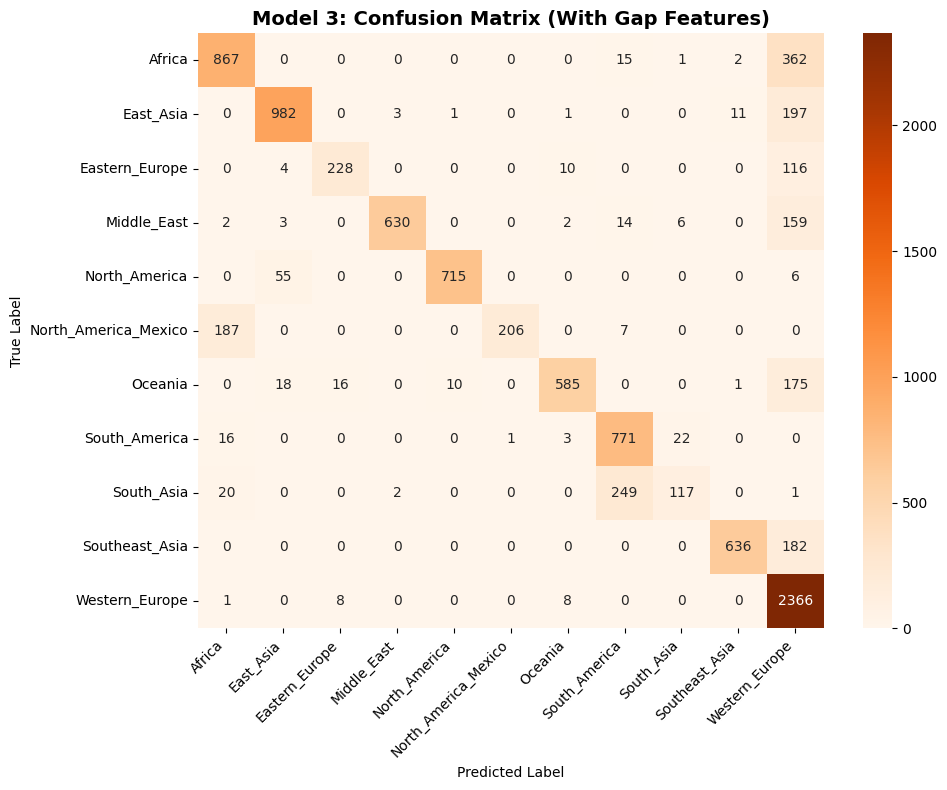

In [22]:
# Model 3: Confusion Matrix
cm3 = confusion_matrix(y_test_3, y_pred_3)
plt.figure(figsize=(10, 8))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=rf_3.classes_, yticklabels=rf_3.classes_)
plt.title('Model 3: Confusion Matrix (With Gap Features)', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Model 3: Feature Importance Analysis

Let's see if those engineered gap features ended up being important for predictions.

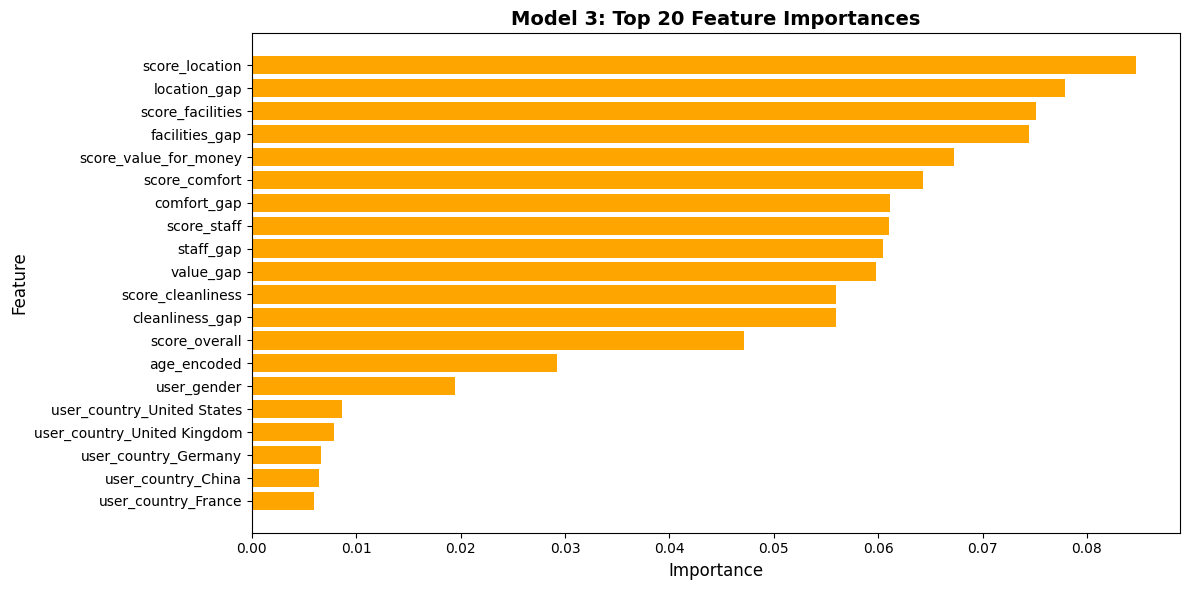

Top 10 Most Important Features for Model 3:
                  feature  importance
4          score_location    0.084679
57           location_gap    0.077880
3        score_facilities    0.075165
56         facilities_gap    0.074462
6   score_value_for_money    0.067302
2           score_comfort    0.064319
55            comfort_gap    0.061127
5             score_staff    0.061010
58              staff_gap    0.060484
59              value_gap    0.059815


In [23]:
# Model 3: Feature Importance
feature_importance_3 = pd.DataFrame({
    'feature': X_train_3.columns,
    'importance': rf_3.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(feature_importance_3.head(20)['feature'], 
         feature_importance_3.head(20)['importance'], 
         color='orange')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Model 3: Top 20 Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features for Model 3:")
print(feature_importance_3.head(10))

## Model Comparison

### Train vs Test Performance

Time to compare all three models side by side. We're looking at both training and test accuracy to spot overfitting - if train accuracy is way higher than test, the model might be memorizing rather than learning.

The gap between train and test tells us how well each model generalizes to new data.

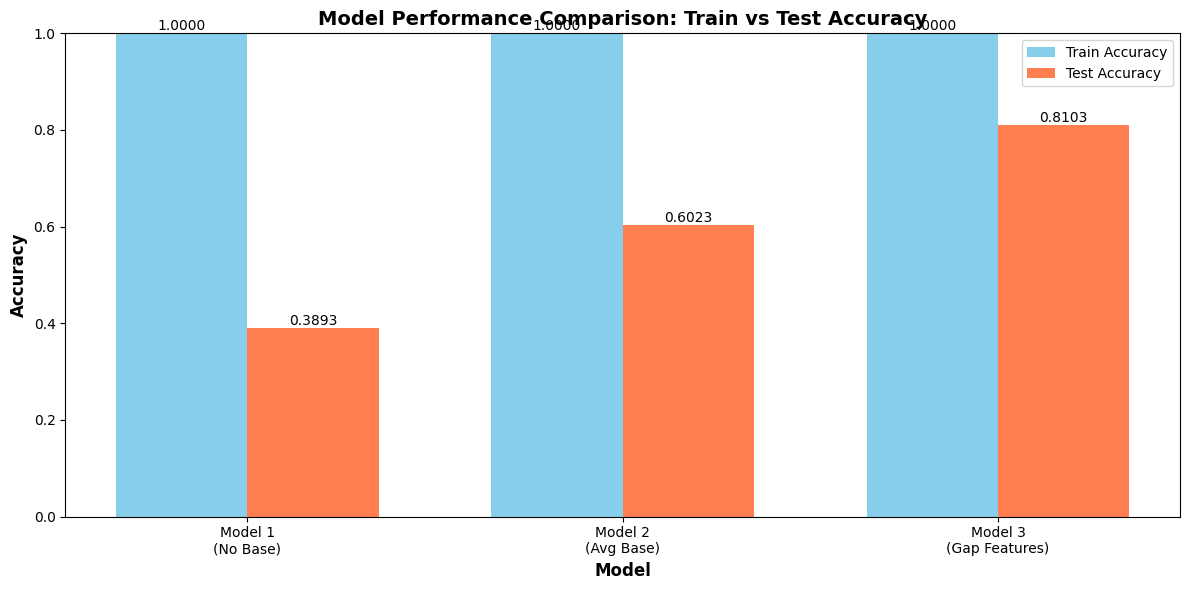


Model Comparison Table:
                  Model  Train Accuracy  Test Accuracy  Overfitting Gap
     Model 1\n(No Base)             1.0         0.3893           0.6107
    Model 2\n(Avg Base)             1.0         0.6023           0.3977
Model 3\n(Gap Features)             1.0         0.8103           0.1897


In [24]:
# Model Performance Comparison
models = ['Model 1\n(No Base)', 'Model 2\n(Avg Base)', 'Model 3\n(Gap Features)']
train_scores = [accuracy_score(y_train_1, rf_1.predict(X_train_1)),
                accuracy_score(y_train_2, rf_2.predict(X_train_2)),
                accuracy_score(y_train_3, rf_3.predict(X_train_3))]
test_scores = [accuracy_score(y_test_1, y_pred_1),
               accuracy_score(y_test_2, y_pred_2),
               accuracy_score(y_test_3, y_pred_3)]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, train_scores, width, label='Train Accuracy', color='skyblue')
bars2 = ax.bar(x + width/2, test_scores, width, label='Test Accuracy', color='coral')

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison: Train vs Test Accuracy', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim([0, 1])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Print comparison table
comparison_df = pd.DataFrame({
    'Model': models,
    'Train Accuracy': train_scores,
    'Test Accuracy': test_scores,
    'Overfitting Gap': [train - test for train, test in zip(train_scores, test_scores)]
})
print("\nModel Comparison Table:")
print(comparison_df.to_string(index=False))

### Detailed Metrics Comparison

Accuracy alone doesn't tell the whole story. Precision, recall, and F1-score give us a more complete picture of model performance, especially for multi-class problems like ours.

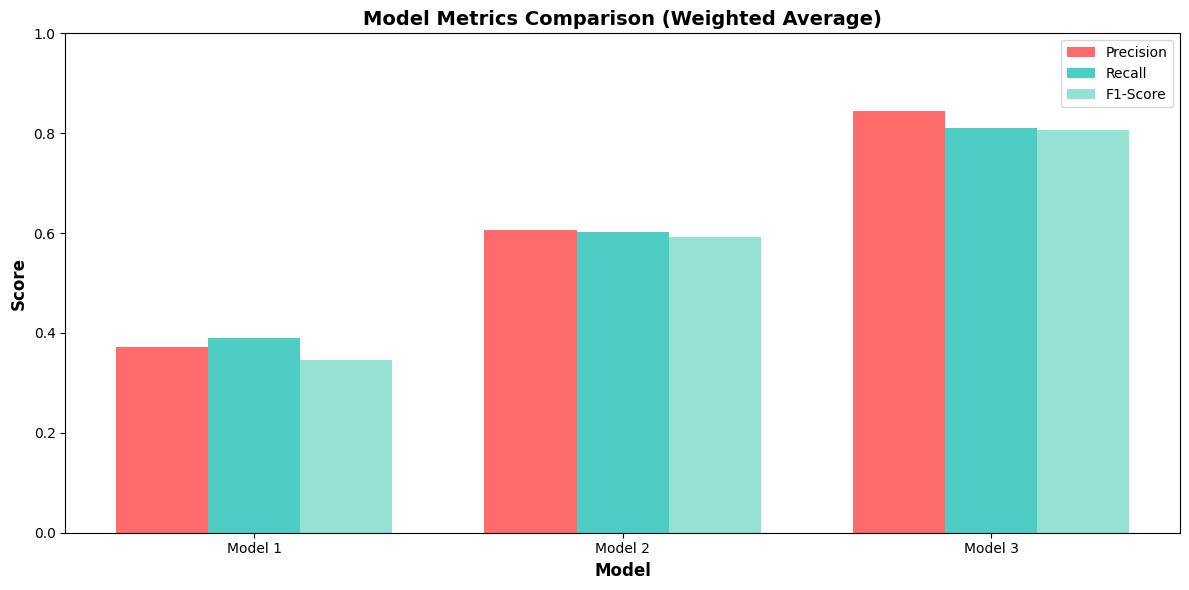


Detailed Metrics Comparison:
  Model  Precision  Recall  F1-Score
Model 1   0.371147  0.3893  0.345128
Model 2   0.605657  0.6023  0.591968
Model 3   0.845088  0.8103  0.806235


In [25]:
# Calculate precision, recall, F1 for all models
from sklearn.metrics import precision_recall_fscore_support

metrics_1 = precision_recall_fscore_support(y_test_1, y_pred_1, average='weighted')
metrics_2 = precision_recall_fscore_support(y_test_2, y_pred_2, average='weighted')
metrics_3 = precision_recall_fscore_support(y_test_3, y_pred_3, average='weighted')

metrics_df = pd.DataFrame({
    'Model': ['Model 1', 'Model 2', 'Model 3'],
    'Precision': [metrics_1[0], metrics_2[0], metrics_3[0]],
    'Recall': [metrics_1[1], metrics_2[1], metrics_3[1]],
    'F1-Score': [metrics_1[2], metrics_2[2], metrics_3[2]]
})

# Plot metrics comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(metrics_df))
width = 0.25

ax.bar(x - width, metrics_df['Precision'], width, label='Precision', color='#FF6B6B')
ax.bar(x, metrics_df['Recall'], width, label='Recall', color='#4ECDC4')
ax.bar(x + width, metrics_df['F1-Score'], width, label='F1-Score', color='#95E1D3')

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Metrics Comparison (Weighted Average)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df['Model'])
ax.legend()
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("\nDetailed Metrics Comparison:")
print(metrics_df.to_string(index=False))

## Explainable AI (XAI)

### Setting Up SHAP and LIME

Now we're going to peek inside the black box. SHAP and LIME help us understand WHY the model makes certain predictions - which features pushed it towards a particular country group.

In [26]:
# !pip install shap lime
import shap


### SHAP Analysis for Model 1

Using SHAP to explain Model 1's predictions. We're taking a sample of 100 test examples and calculating SHAP values - these tell us how much each feature contributed to each prediction.

The bar plot shows overall feature importance across all predictions.

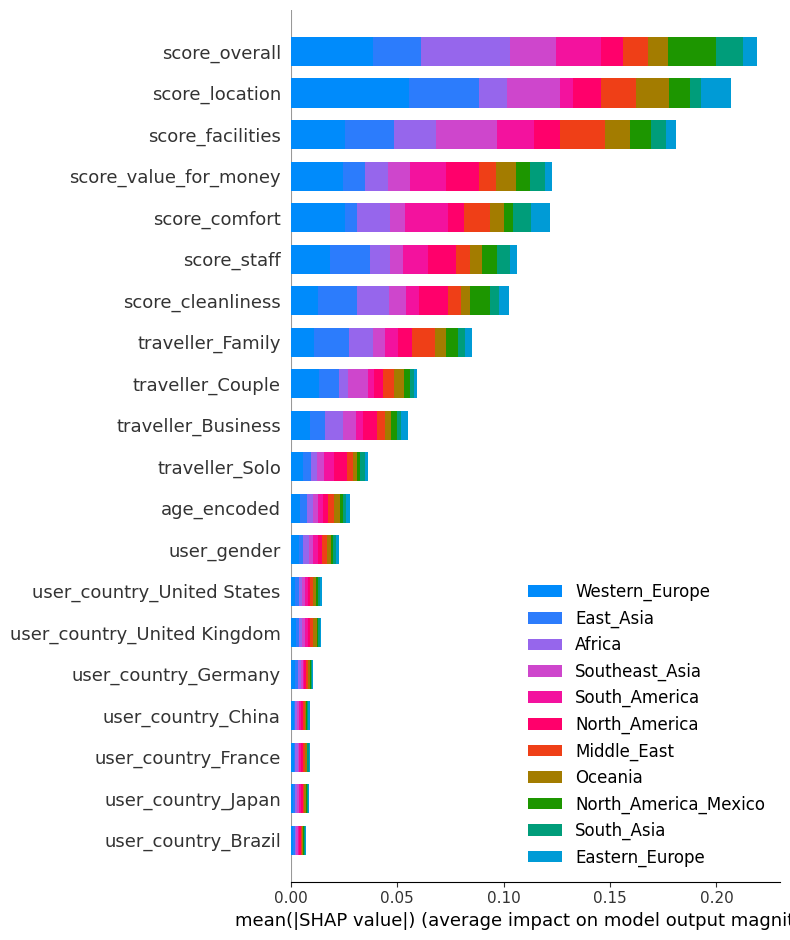

In [27]:
# shap and lime for model 1 to understand feature importance
explainer = shap.TreeExplainer(rf_1)
X_test_sample = X_test_1.sample(n=100, random_state=42)
shap_values = explainer.shap_values(X_test_sample)

# Bar plot
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", class_names=rf_1.classes_)
plt.show()



### SHAP Summary Plot for Model 1

This beeswarm plot:- each dot is one prediction, and we can see how feature values (red = high, blue = low) affect predictions across all country groups.

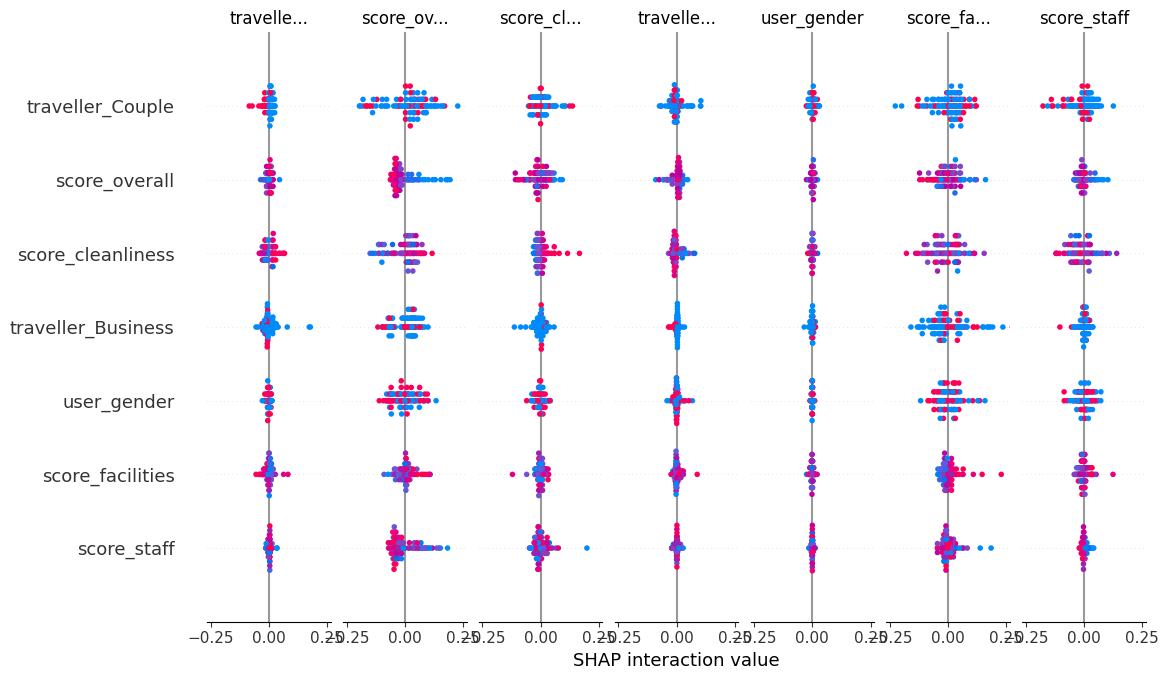

In [28]:
shap.summary_plot(shap_values, X_test_sample)
plt.show()

### SHAP Local Explanation (Single Prediction)

Zooming in on one specific prediction. The waterfall plot shows exactly how each feature pushed the prediction up or down from the baseline. This is super useful for understanding individual decisions.

Sample 0: Predicted Western_Europe


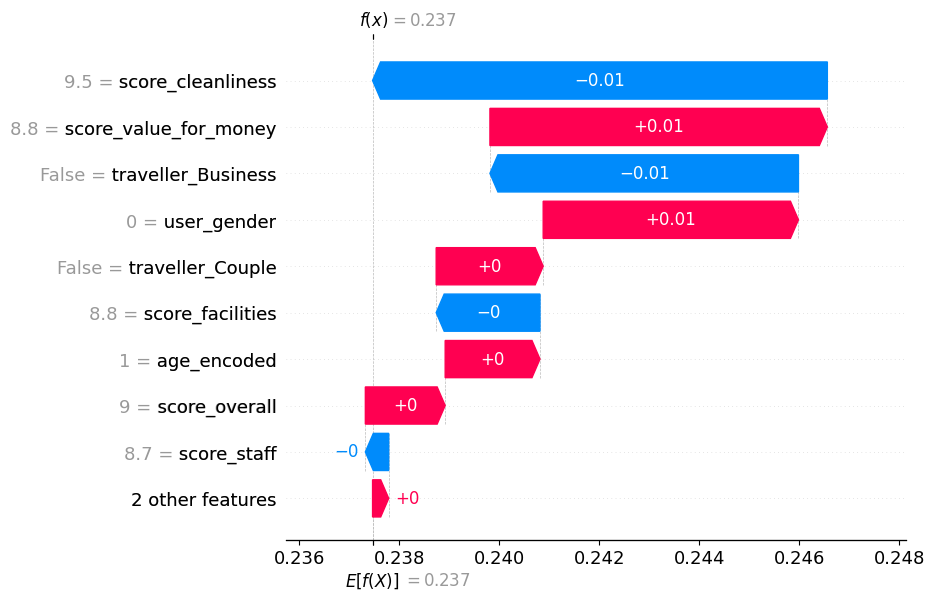

In [29]:
# Pick a sample to explain
i = 0
predicted_class = rf_1.predict(X_test_sample.iloc[[i]])[0]
class_idx = list(rf_1.classes_).index(predicted_class)

print(f"Sample {i}: Predicted {predicted_class}")

# Waterfall plot shows local explanation
shap.waterfall_plot(shap.Explanation(
    values=shap_values[class_idx][i],
    base_values=explainer.expected_value[class_idx],
    data=X_test_sample.iloc[i].values,
    feature_names=X_test_sample.columns.tolist()
))

### LIME Setup for Model 1

Setting up LIME (Local Interpretable Model-agnostic Explanations). While SHAP gives us global insights, LIME is great for explaining individual predictions by creating a simpler, interpretable model around that specific point.

In [30]:
import lime.lime_tabular

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train_1.values,
    feature_names=X_train_1.columns.tolist(),
    class_names=rf_1.classes_.tolist(),
    mode='classification'
)

### LIME Explanation Example

Here's LIME in action for one prediction. It shows which features were most important for THIS specific prediction and how they influenced it.

In [31]:
i = 4

exp = explainer_lime.explain_instance(
    X_test_1.iloc[i].values,
    rf_1.predict_proba,
    num_features=10
)

print(f"Sample {i}: Predicted {rf_1.predict(X_test_1.iloc[[i]])[0]}")


Sample 4: Predicted East_Asia


### SHAP Analysis for Model 2

Same SHAP analysis but for Model 2 (the one with averaged base features). Let's see if the importance rankings changed.

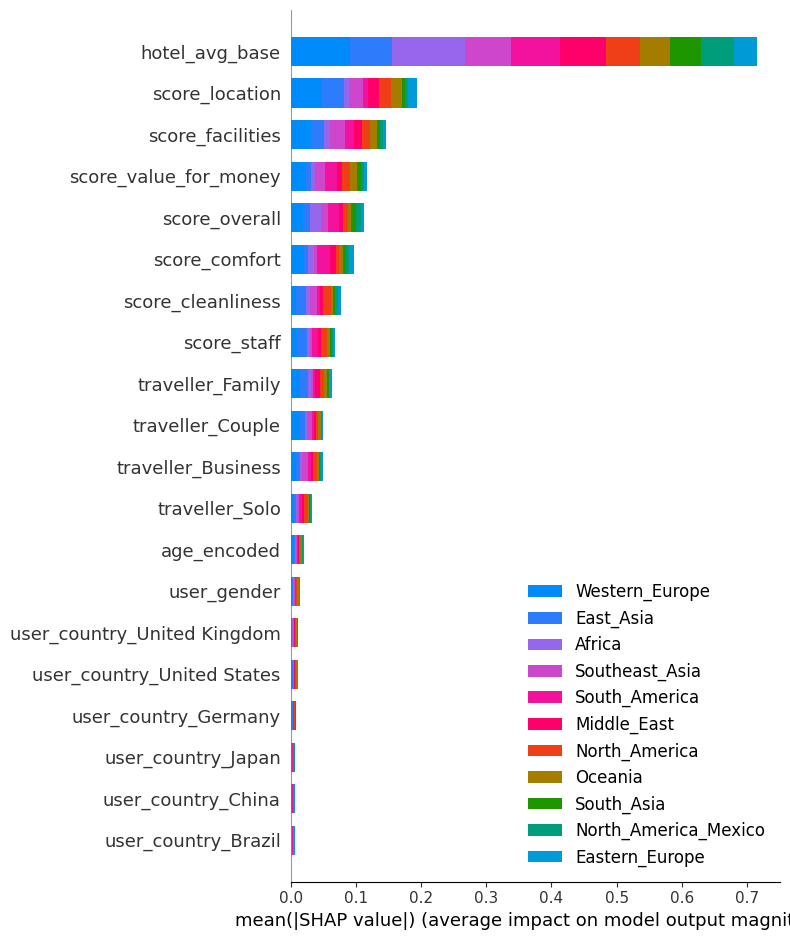

In [32]:
# shap and lime for model 2 to understand feature importance
explainer = shap.TreeExplainer(rf_2)
X_test_sample = X_test_2.sample(n=100, random_state=42)
shap_values = explainer.shap_values(X_test_sample)

# Bar plot
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", class_names=rf_2.classes_)
plt.show()



SHAP beeswarm plot for Model 2.

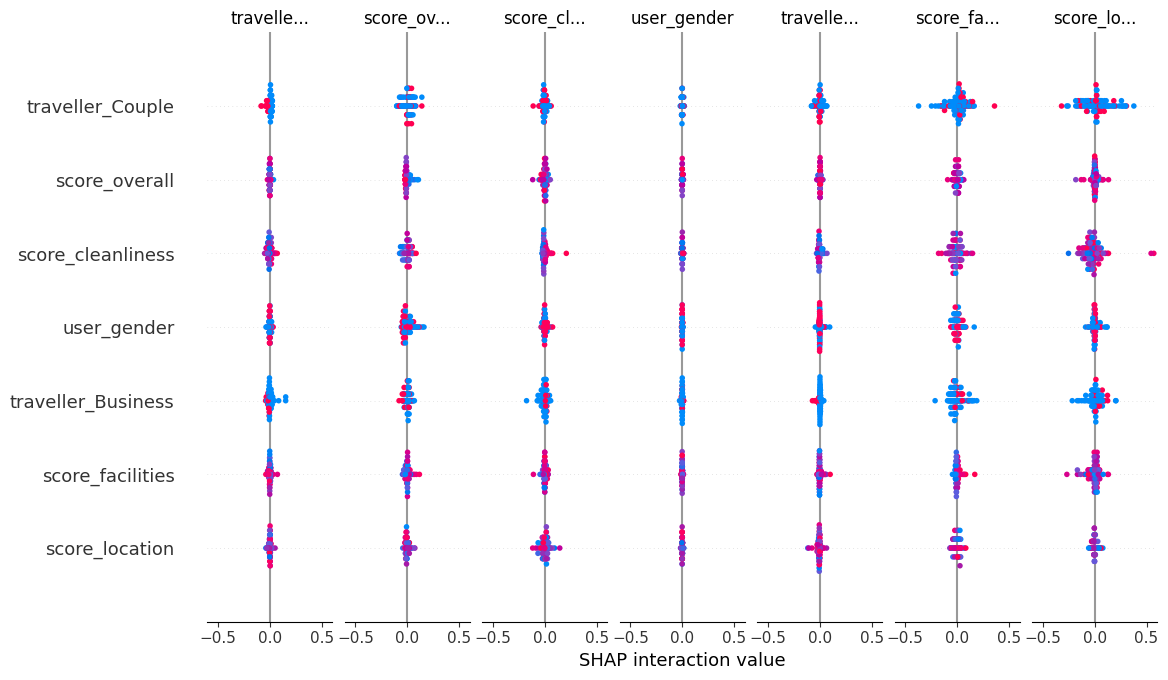

In [33]:
shap.summary_plot(shap_values, X_test_sample)
plt.show()

Local explanation for a specific prediction from Model 2.

Sample 0: Predicted Middle_East


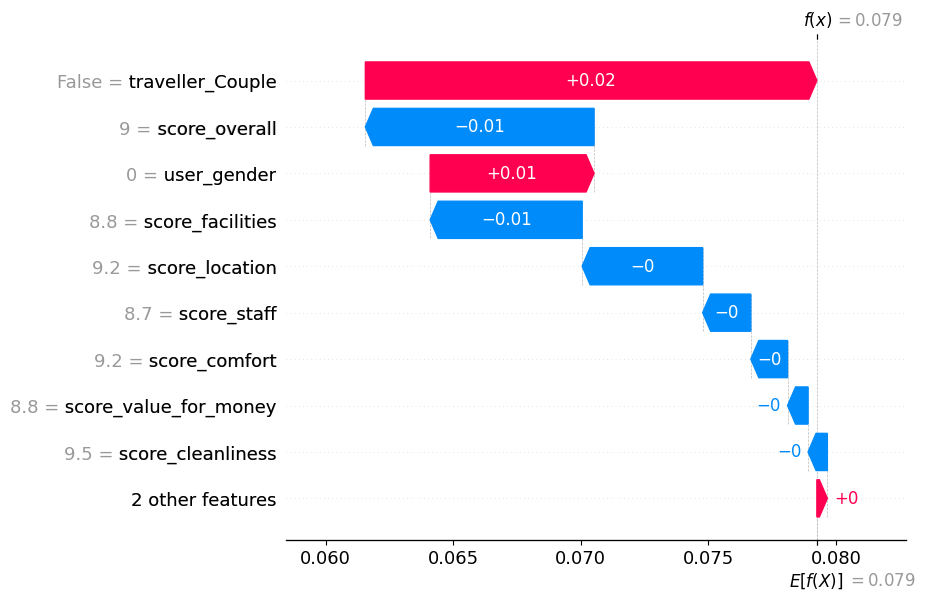

In [34]:
# Pick a sample to explain
i = 0
predicted_class = rf_2.predict(X_test_sample.iloc[[i]])[0]
class_idx = list(rf_2.classes_).index(predicted_class)

print(f"Sample {i}: Predicted {predicted_class}")

# Waterfall plot shows local explanation
shap.waterfall_plot(shap.Explanation(
    values=shap_values[class_idx][i],
    base_values=explainer.expected_value[class_idx],
    data=X_test_sample.iloc[i].values,
    feature_names=X_test_sample.columns.tolist()
))

Setting up LIME for Model 2 explanations.

In [35]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train_2.values,
    feature_names=X_train_2.columns.tolist(),
    class_names=rf_2.classes_.tolist(),
    mode='classification'
)

LIME explanation for a single prediction from Model 2.

In [36]:
i = 4

exp = explainer_lime.explain_instance(
    X_test_2.iloc[i].values,
    rf_2.predict_proba,
    num_features=10
)

print(f"Sample {i}: Predicted {rf_2.predict(X_test_2.iloc[[i]])[0]}")
exp.show_in_notebook(show_table=True)

Sample 4: Predicted Middle_East


### SHAP Analysis for Model 3

Finally, SHAP analysis for Model 3 (with gap features). This should show us if those engineered features really made a difference in what the model pays attention to.

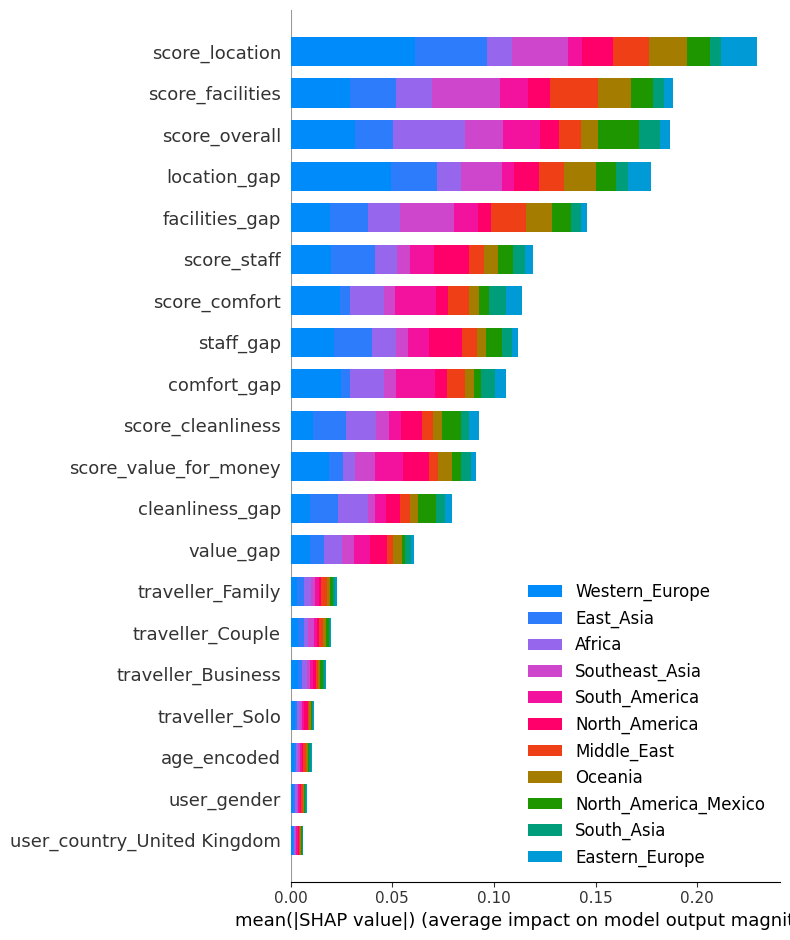

In [37]:
# shap and lime for model 3 to understand feature importance
explainer = shap.TreeExplainer(rf_3)
X_test_sample = X_test_3.sample(n=100, random_state=42)
shap_values = explainer.shap_values(X_test_sample)

# Bar plot
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", class_names=rf_3.classes_)
plt.show()


SHAP beeswarm plot for Model 3. Notice if the gap features show up as important.

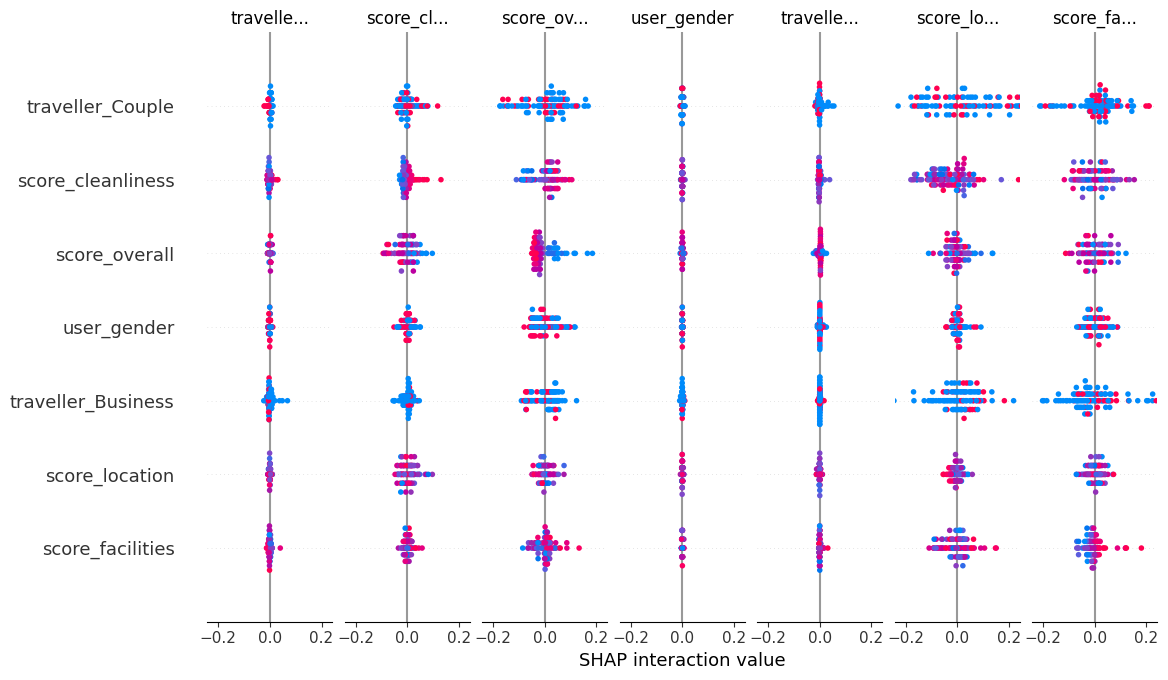

In [38]:
shap.summary_plot(shap_values, X_test_sample)
plt.show()

Local explanation for Model 3. How do the gap features influence individual predictions?

Sample 0: Predicted Oceania


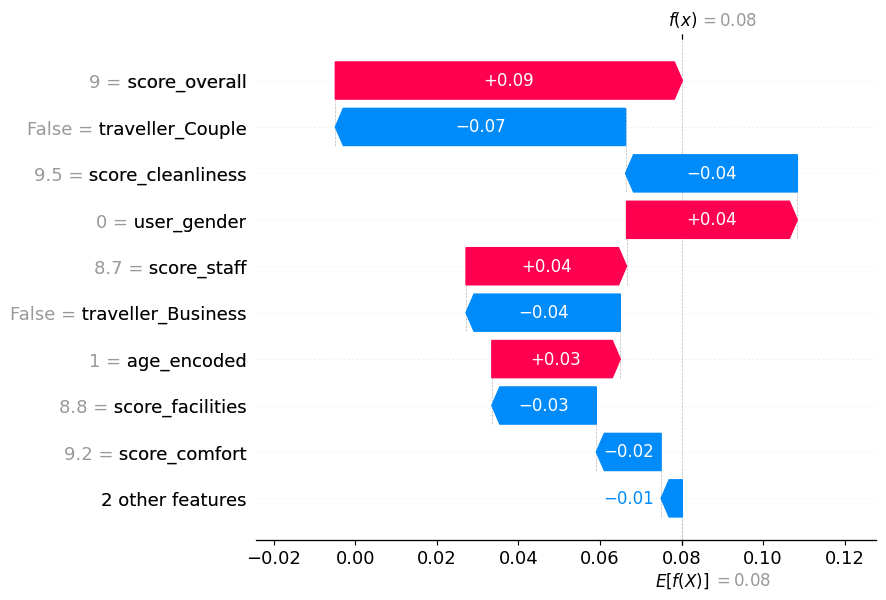

In [39]:
# Pick a sample to explain
i = 0
predicted_class = rf_3.predict(X_test_sample.iloc[[i]])[0]
class_idx = list(rf_3.classes_).index(predicted_class)

print(f"Sample {i}: Predicted {predicted_class}")

# Waterfall plot shows local explanation
shap.waterfall_plot(shap.Explanation(
    values=shap_values[class_idx][i],
    base_values=explainer.expected_value[class_idx],
    data=X_test_sample.iloc[i].values,
    feature_names=X_test_sample.columns.tolist()
))

Setting up LIME for Model 3.

In [40]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train_3.values,
    feature_names=X_train_3.columns.tolist(),
    class_names=rf_3.classes_.tolist(),
    mode='classification'
)

LIME local explanation for Model 3.

In [41]:
i = 4

exp = explainer_lime.explain_instance(
    X_test_3.iloc[i].values,
    rf_3.predict_proba,
    num_features=10
)

print(f"Sample {i}: Predicted {rf_3.predict(X_test_3.iloc[[i]])[0]}")
exp.show_in_notebook(show_table=True)

Sample 4: Predicted Middle_East


## Inference Function

### Making Predictions on New Data

This function lets us use our trained model on brand new data. It takes raw input (like you'd get from a form), applies the same preprocessing we used during training, and returns a prediction in plain English.

We're showing a few examples to demonstrate that it works with different types of users.

In [42]:
def predict_country_group(model,feature_names, user_data):
    """
    user_data: list of values or dict of {column: value}
    model: trained RandomForest model
    feature_names: list of feature names in correct order
    """


    preprocessed_data= preprocessing(user_data, "TEST")
    prediction = model.predict(preprocessed_data)[0]
    print("Predicted country_group:", prediction)
    return prediction

feature_names = [
    'score_overall',
    'score_cleanliness',
    'score_comfort',
    'score_facilities',
    'score_location',
    'score_staff',
    'score_value_for_money',
    'user_gender',
    'user_country',
    'age_group',
    'traveller_type'
]


user_data1 = [
    9.5,            # score_overall
    9.6,            # score_cleanliness
    8.3,            # score_comfort
    8.6,            # score_facilities
    9.2,            # score_location
    8.8,            # score_staff
    8.8,            # score_value_for_money
    'Male',       # user_gender
    'Thailand',      # user_country
    '35-44',        # age_group
    'Family'        # traveller_type
]
user_df = pd.DataFrame([user_data1], columns=feature_names)
predict_country_group(rf_1, feature_names, user_df)

# first_row_df= first_row_df.drop(columns=['country_group', 'comfort_base', 'facilities_base', 'location_base', 'staff_base', 'value_for_money_base', 'cleanliness_base'
# ])
# predict_country_group(rf_1, feature_names, first_row_df)



No unnecessary columns to drop.
Encoded user_gender.
Encoded age_group → age_encoded.
One-hot encoded traveller_type.
One-hot encoded user_country.
Preprocessed Data
   score_overall  score_cleanliness  score_comfort  score_facilities  \
0            9.5                9.6            8.3               8.6   

   score_location  score_staff  score_value_for_money  user_gender  \
0             9.2          8.8                    8.8            0   

   age_encoded  traveller_Business  ...  user_country_South Africa  \
0            2               False  ...                      False   

   user_country_South Korea  user_country_Spain  user_country_Thailand  \
0                     False               False                   True   

   user_country_Turkey  user_country_United Arab Emirates  \
0                False                              False   

   user_country_United Kingdom  user_country_United States  \
0                        False                       False   

   user_co

'South_America'